In [1]:
# imports
from astropy.io import fits

import numpy as np

from astroquery.simbad import Simbad
from astroquery.mast import Observations
from astroquery.vizier import Vizier

from astropy.table import Table, vstack
import astropy.units as u
import astropy.coordinates as coord

%matplotlib inline
import matplotlib.pyplot as plt

import os
import json

import requests

# detrender imports
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import scipy.optimize

In [2]:
# plotting parameters
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

# INPUT TIC NUMBER


    Tess Input Catalog # TIC

In [3]:
# edit these values
tic_id = 'TIC 172900988'
download_path ='lc_downloads'

# Query

simple astropy MAST query to get observation ids for time series photometry observations

In [4]:
obs_table = Observations.query_object(tic_id, radius='0 deg')
w = []
for row in obs_table:
    if row['dataproduct_type'] == 'timeseries':
        w.append(True)
    else:
        w.append(False)
obs_table = obs_table[w]
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str5,str9,str10,str4,str4,str16,str19,str1,str58,float64,float64,str10,str19,int64,float64,float64,float64,float64,float64,str14,float64,str13,str3,int64,str133,str136,str130,str6,bool,float64,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,172900988,--,tess2019199201929-s0014-s0050-0000000172900988,128.661697628763,31.554078073408,timeseries,"Ricker, George",3,59499.67992474537,59606.44508128472,120.0,600.0,1000.0,--,59766.0,N/A,--,50,CIRCLE 128.66169763 31.55407807 0.00138889,--,mast:TESS/product/tess2019199201929-s0014-s0050-0000000172900988-00611_dvt.fits,PUBLIC,False,nan,87589264,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,172900988,--,tess2021233042500-s0042-s0046-0000000172900988,128.661697628763,31.554078073408,timeseries,"Ricker, George",3,59499.67992474537,59578.20570427083,120.0,600.0,1000.0,--,59641.0,G04157_G04103,--,46,CIRCLE 128.66169763 31.55407807 0.00138889,--,mast:TESS/product/tess2021233042500-s0042-s0046-0000000172900988-00550_dvt.fits,PUBLIC,False,nan,71745884,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,172900988,--,tess2021284114741-s0044-0000000172900988-0215-s,128.661697628763,31.554078073408,timeseries,"Ricker, George",3,59499.70214905093,59523.940602905095,120.0,600.0,1000.0,--,59563.0,G04157_G04103,--,44,CIRCLE 128.66169763 31.55407807 0.00138889,--,mast:TESS/product/tess2021284114741-s0044-0000000172900988-0215-s_lc.fits,PUBLIC,False,nan,68729368,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,172900988,--,tess2021310001228-s0045-0000000172900988-0216-s,128.661697628763,31.554078073408,timeseries,"Ricker, George",3,59525.226835243055,59550.127641238425,120.0,600.0,1000.0,--,59575.0,G04157_G04103,--,45,CIRCLE 128.66169763 31.55407807 0.00138889,--,mast:TESS/product/tess2021310001228-s0045-0000000172900988-0216-s_lc.fits,PUBLIC,False,nan,71240519,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,172900988,--,tess2021336043614-s0046-0000000172900988-0217-s,128.661697628763,31.554078073408,timeseries,"Ricker, George",3,59551.50411119213,59578.20570427083,120.0,600.0,1000.0,--,59603.0,G04157_G04103,--,46,CIRCLE 128.66169763 31.55407807 0.00138889,--,mast:TESS/product/tess2021336043614-s0046-0000000172900988-0217-s_lc.fits,PUBLIC,False,nan,71491465,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,172900988,--,tess2021364111932-s0047-0000000172900988-0218-s,128.661697628763,31.554078073408,timeseries,"Ricker, George",3,59579.31963453704,59606.44508128472,120.0,600.0,1000.0,--,59621.0,G04157_G04103,--,47,CIRCLE 128.66169763 31.55407807 0.00138889,--,mast:TESS/product/tess2021364111932-s0047-0000000172900988-0218-s_lc.fits,PUBLIC,False,nan,71657656,0.0
science,HLSP,QLP,Photometer,TESS,TESS,Optical,172900988,--,hlsp_qlp_tess_ffi_s0021-0000000172900988_tess_v01_llc,128.661697629,31.5540780734,timeseries,Chelsea X. Huang,4,58869.95388137,58897.2658456,1800.0,600.0,1000.0,--,59174.53357635,N/A,--,21,CIRCLE ICRS 128.66169763 31.55407807 0.00111111,--,mast:HLSP/qlp/s0021/0000/0001/7290/0988/hlsp_qlp_tess_ffi_s0021-0000000172900988_tess_v01_llc.fits,PUBLIC,False,nan,36312264,0.0
science,HLSP,QLP,Photometer,TESS,TESS,Optical,172900988,--,hlsp_qlp_tess_ffi_s0044-0000000172900988_tess_v01_llc,128.661697629,31.5540780734,timeseries,Chelsea X. Huang,4,59499.68977682572,59523.935176,600.0,600.0,1000.0,--,59935.38761574,N/A,--,44,CIRCLE 128.661697629 31.5540780734 0.0011111111111111111,--,mast:HLSP/qlp/s0044/0000/0001/7290/0988/hlsp_qlp_tess_ffi_s0044-0000000172900988_tess_v01_llc.fits,PUBLIC,False,nan,106978048,0.0
science,HLSP,QLP,Photometer,TESS,TESS,Optical,172900988,--,hlsp_qlp_tess_ffi_s0045-0000000172900988_tess_v01_llc,128.66169762

# Downloading Package

    Uses obs_ids and requests to download the TESS lightcurve file from MAST

In [5]:
def download_request(download_path, products):
    download_url = 'https://mast.stsci.edu/api/v0.1/Download/file?'

    for row in products:     

        # make file path
        out_path = download_path + '/' + row['productFilename']

        # Download the data
        payload = {"uri":row['dataURI']}
        resp = requests.get(download_url, params=payload)
        
        # save to file
        file = open(out_path,'wb')
        file.write(resp.content)
        file.close()

        # check for file 
        if not os.path.isfile(out_path):
            print("ERROR: " + out_path + " failed to download.")
        else:
            print("COMPLETE: ", out_path)
            
def acquire_tess_products(path, tic_id, rad='0 deg'):
    """tic_id format -> TIC 12345..."""
    
    
    # check if the output file path exists
    download_path = path + '/' + tic_id[4:]
    if not os.path.exists(download_path):
        os.makedirs(download_path)
        
    # find and filter tables
    print('SEARCHING MAST FOR OBSERVATIONS')
    obs_table = Observations.query_object(tic_id, radius=rad)
    w = obs_table['target_name'] == tic_id[4:]
    obs_table = obs_table[w]
    
    print('SEARCHING FOR DATA PRODUCTS')
    products = Observations.get_product_list(obs_table)
    w = products['productType'] == 'SCIENCE'
    products = products[w]
    w = []
    for row in products:
        cr = row['dataURI'][-7:]
        if cr == 'lc.fits':
            w.append(True)
        else:
            w.append(False)
    products = products[w]
    product_table = products
            
    # download products
    print('DOWNLOADING PRODUCTS')
    download_request(download_path, product_table)
    print()
    print('TASK COMPLETE')
    return product_table

### Run the cell below to download target files

In [6]:
# downloads the products
table = acquire_tess_products(download_path, tic_id)

SEARCHING MAST FOR OBSERVATIONS
SEARCHING FOR DATA PRODUCTS
DOWNLOADING PRODUCTS
COMPLETE:  lc_downloads/172900988/hlsp_qlp_tess_ffi_s0021-0000000172900988_tess_v01_llc.fits
COMPLETE:  lc_downloads/172900988/hlsp_qlp_tess_ffi_s0044-0000000172900988_tess_v01_llc.fits
COMPLETE:  lc_downloads/172900988/hlsp_qlp_tess_ffi_s0045-0000000172900988_tess_v01_llc.fits
COMPLETE:  lc_downloads/172900988/hlsp_qlp_tess_ffi_s0046-0000000172900988_tess_v01_llc.fits
COMPLETE:  lc_downloads/172900988/hlsp_qlp_tess_ffi_s0047-0000000172900988_tess_v01_llc.fits
COMPLETE:  lc_downloads/172900988/hlsp_tess-spoc_tess_phot_0000000172900988-s0021_tess_v1_lc.fits
COMPLETE:  lc_downloads/172900988/hlsp_tess-spoc_tess_phot_0000000172900988-s0044_tess_v1_lc.fits
COMPLETE:  lc_downloads/172900988/hlsp_tess-spoc_tess_phot_0000000172900988-s0045_tess_v1_lc.fits
COMPLETE:  lc_downloads/172900988/hlsp_tess-spoc_tess_phot_0000000172900988-s0046_tess_v1_lc.fits
COMPLETE:  lc_downloads/172900988/hlsp_tess-spoc_tess_phot_000

# File reader for desired time series files

Output: astropy table containing 'TIME', 'FLUX', 'FLUX_ERR','RAW_FLUX','RAW_FLUX_ERR'

    Options:

    1 - short cadence data only
    2 - long cadence data
    3 - all options (default)

In [7]:
def load_tess_data(file, time_adj):
    # time adjustment can be used to adjust dates
    hdul = fits.open(file)
    data = hdul[1].data
    w = data['QUALITY'] == 0
    data = data[w]
    header = ['TIME', 'FLUX', 'FLUX_ERR','RAW_FLUX','RAW_FLUX_ERR']
    time = data['TIME']
    flux = data['SAP_FLUX']
    try:
        err = data['SAP_FLUX_ERR']
    except:
        err = data['SAP_BKG_ERR']
    data = Table([time, flux, err, flux, err], names = header)
    w = data['TIME'] > -1000000
    data = data[w]
    w = data['FLUX'] > 0
    data = data[w]
    w = data['FLUX_ERR'] > 0
    data['FLUX_ERR'] = data['FLUX_ERR'] / np.median(data['FLUX'])
    data['TIME'] = data['TIME'] + time_adj
    data['FLUX'] = data['FLUX'] / np.median(data['FLUX'])
    return data

# find the files 
def check_fits_timeseries(download_path, tic_id, time_adj=0, option=3):
    download_path = download_path + '/' + tic_id[4:] + '/'

    # creating dictionaries for the possible sources
    files_list = os.listdir(download_path)
    files_list.sort()
    d = {}
    d_tess = {}
    d_qlp = {}
    d_spoc = {}
    for file in files_list:
        temp_f = file.split('-')
        sec_type = file.split('_')[1]
        if file[0:4] == 'tess':
            sector = temp_f[1][-2:]
            d_tess[sector] = file
        elif sec_type == 'qlp':
            sector = temp_f[0][-5:]
            d_qlp[sector] = file
        elif sec_type == 'tess-spoc':
            sector = temp_f[-1][0:5]
            d_spoc[sector] = file

    # choosing options
    if option==1: # you only want short cadence data
        d = d_tess
    elif option==2: # want only quick look which is long cadence
        d = d_qlp
    elif option==3: # want all options
        used_keys = []
        for key in d_tess:
            d[key] = d_tess[key]
            used_keys.append(key)
        for key in d_spoc:
            if key not in used_keys:
                d[key] = d_spoc[key]
                used_keys.append(key)
        for key in d_qlp:
            if key not in used_keys:
                d[key] = d_qlp[key]
                used_keys.append(key)
            
    files_list = []
    # add all files to the file list
    for key in d:
        files_list.append(d[key])
        

    # put files in a data array
    DATA = []
    for file in files_list:
        try:
            data = load_tess_data(download_path + file, time_adj)
            DATA.append(data)
        except:
            None
    print(f'{len(DATA)} files found with time series data')

    return DATA

### grab the data
can change the time_adj for adjusting the date format or the option for what cadence is desired

In [8]:
DATA = check_fits_timeseries(download_path, tic_id, time_adj=2000, option=1)

4 files found with time series data


# Example Plot

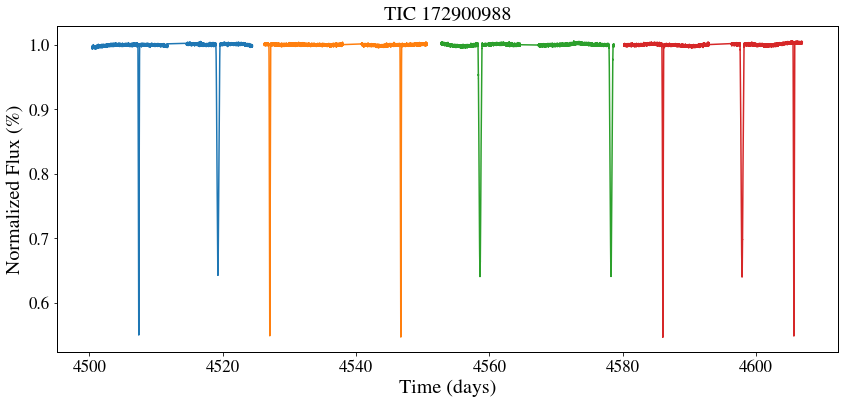

In [9]:
plt.figure(figsize=(14,6),facecolor=(1,1,1))
for d in DATA:
    plt.plot(d['TIME'], d['FLUX'])
#plt.xlim(2164,2165)
#plt.ylim(0.996,1.005)
MASTER_TABLE = vstack(DATA)
MASTER_TABLE.sort('TIME')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(tic_id, fontsize=20)
plt.ylabel('Normalized Flux (%)')
plt.xlabel('Time (days)')
plt.show();

<hr style="border:2px solid blue">

# Additional Section for binary systems

## Period Finder / String Length Module

Section to find the orbital period of the binary system numerically. 

string length modules

In [10]:
"""STRING LENGTH CALCULATOR"""
def string_length(period, time, var):
    """
    Return the "length of the string" connecting magnitude measurements phased
    to some given period.
    
    `period` -- (float) the (test) period in days
    `time` -- a numpy array with the time in days from some epoch
    `var` -- variable we are trying to phase
    """

    # convert the time to phase (covering the interval 0 to 1)
    phase = time % period / period
    
    # scale the magnitudes for proper weighting 
    # see equation 3 from Dworetsky 1983
    V = (var - np.max(var)) / 2 * (np.max(var) - np.min(var)) - 0.25
    
    #step where you have a table or a zip phase, m 
    table = Table([phase, V], names=('phase', 'var'))
    
    # sort by phase
    wsort = table.argsort('phase')
    phase = phase[wsort]
    V = V[wsort]

    # calculate the string length
    # see equation 2 from Dworetsky 1983
    length = 0
    n = len(V)
    
    length = V[0] + V[n-1]
    for i in range(n-1):
        #chunk_1 = np.sqrt((V[i] - V[i-1])**2 + (phase[i] - phase[i-1])**2) 
        #chunk_2 = np.sqrt((V[0] - V[-1])**2 + (phase[0] - phase[-1] + 1)**2)
        #length += chunk_1 + chunk_2
        length += abs(V[i]-V[i+1])
    
    # return the total length
    return length

def test_periods(time, flux, pmin, pmax, pdelta):
    """
    Determine the string length for a range of periods
    
    pmin -- the minimum period (in days) to test
    pmax -- the maximum period (in days) to test
    pdelta -- the period resolution in days (e.g. do (pmax - pmin) / pdelta tests)
    """
    
    # define the test periods
    periods = np.arange(pmin, pmax, pdelta)
    
    # get the string length for each of these
    lengths = np.array([string_length(period, time, flux) for period in periods])
    
    return periods, lengths

def SL_module(time, flux, x, y, h):
    periods, lengths = test_periods(time, flux, x, y, h)
    best_P = periods[lengths == np.min(lengths)][0]
    return best_P, periods, lengths

Display Modules

In [11]:
# display modules
def display_phased(time, flux, best_period, t0, prim_width, prim_depth, sec_phase, sec_width, sec_depth):
    per = round(best_period, 5)
    #tname = 'Phased spu106 Radial Velocities P={}'.format(per)
    fig = plt.figure(figsize=(8,5),facecolor=(1,1,1))
    #plt.title(tname)
    plt.xlabel(r'Phase ($\phi$)')
    plt.ylabel('Normalized Flux (%)')
    plt.xlim(-0.2,1.2)
    plt.locator_params(axis='both', nbins=10)
    phase = (time-t0) % best_period / best_period
    plt.scatter(phase, flux, s=0.1, c='k')
    plt.scatter(phase+1, flux, s=0.1, c='k')
    plt.scatter(phase-1, flux, s=0.1, c='k')
    plt.axvline(1, ls='--', c='r')
    plt.axvline(sec_phase, ls='--', c='b')
    plt.axvline(0, ls='--', c='r')
    plt.title('P={} days'.format(per))
    plt.show();
    
    # primary
    fig = plt.figure(figsize = (5,5), facecolor=(1,1,1))
    plt.scatter(phase-1, flux, s=0.1, c='k')
    plt.scatter(phase, flux, s=0.1, c='k')
    plt.xlim([0-prim_width-0.01,prim_width+0.01])
    plt.axvline(0, ls='--', c='r')
    plt.axvspan(0-prim_width, 0+prim_width, alpha=0.2, color='red')
    plt.axhspan(np.median(flux), np.median(flux)-prim_depth, alpha=0.2, color='blue')
    plt.title(r'Primary, $T_0$ = {}, Width = {}'.format(t0, prim_width),fontsize=17)
    plt.xlabel(r'Phase ($\phi$)')
    plt.ylabel('Normalized Flux (%)')
    plt.show();
    
    # secondary
    fig = plt.figure(figsize = (5,5), facecolor=(1, 1, 1))
    plt.scatter(phase-1, flux, s=0.1, c='k')
    plt.scatter(phase, flux, s=0.1, c='k')
    plt.xlim([sec_phase-sec_width-0.01,sec_phase+sec_width+0.01])
    plt.axvline(sec_phase, ls='--', c='b')
    plt.axvspan(sec_phase-sec_width, sec_phase+sec_width, alpha=0.2, color='red')
    plt.axhspan(np.median(flux), np.median(flux)-sec_depth, alpha=0.2, color='blue')
    plt.title(r'Secondary Phase = {}, Width = {}'.format(sec_phase, sec_width), fontsize=17)
    plt.xlabel(r'Phase ($\phi$)')
    plt.ylabel('Normalized Flux (%)')
    plt.show();
    
    params = [t0, prim_width, prim_depth, sec_phase, sec_width, sec_depth]
    return params

def display_strings(periods, lengths, best_period):
    per = round(best_period, 8)
    tname = 'spu106 String Lengths'.format(per)
    plt.figure(figsize=(8,5))
    #plt.title(tname)
    min_s = min(lengths)
    idx = np.where(lengths == min_s)
    plt.xlabel('Period (days)')
    plt.ylabel('String Length')
    plt.locator_params(axis='both', nbins=10)
    plt.scatter(periods, lengths, c='k', s=0.5)
    plt.scatter(periods[idx], lengths[idx], c='r', s=10)
    x = np.max(periods) * 0.6
    y = (np.max(lengths)+ 0.2*np.max(lengths)) * 0.9
    plt.title('S={}'.format(round(min_s,5)))
    plt.show();
    return

### How to run?

replace 19.6 with the guess for the lowest bound of the orbital period

replace 19.7 with the guess for the upper bound of the orbital period

replace 0.001 with the stepsize of your choosing (will increase processing time)

In [12]:
best_P, periods, lengths = SL_module(MASTER_TABLE['TIME'], MASTER_TABLE['FLUX'], 19.6, 19.7, 0.0001)

Display the phased lightcurve to confirm the found period is not an alias period. Adjust the parameters after best_P in order to match the eclipse depths, widths, and phase of minimum light. (note the primary occurs at phase 0)

Order of parameters to edit after best_P:

1) T0 - reference time for primary eclipse

2) Phase width of the primary eclipse (red shaded section)

3) Depth of the primary eclipse (blue shaded section)

4) Secondary phase (dashed vertical line alined with the minimum light of the secondary eclipse)

5) Secondary width (red shaded section)

6) Secondary depth (blue shaded section)

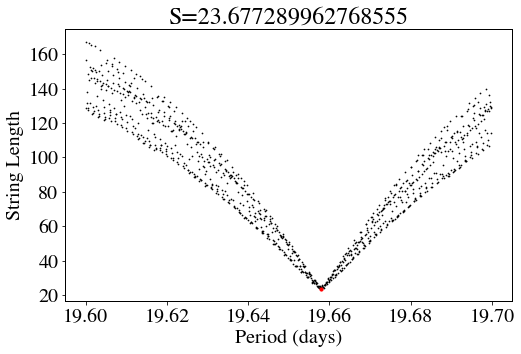

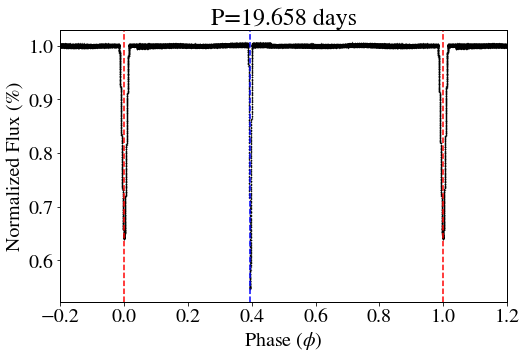

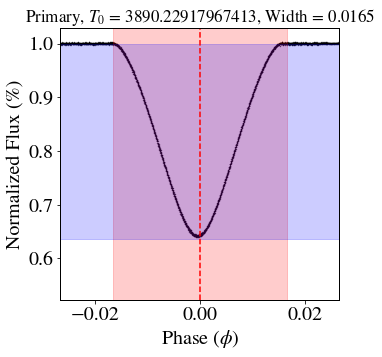

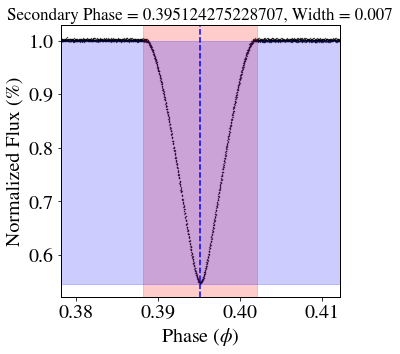

In [13]:
display_strings(periods, lengths, best_P)
params = display_phased(MASTER_TABLE['TIME'], MASTER_TABLE['FLUX'], best_P, 3890.22917967413, 0.0165, 0.363832804855119, 0.395124275228707, 0.007, 0.455106739013855)

# Predict the Eclipses

In order to detrend the data we need the eclipse times using the save parameters from the previous step

In [14]:
def predicted_eclipses(t0, start, stop, P, sec_phase):
    predicted_eclipses = {}
    cycle = int((start - t0) // P)
    time = start
    while time < stop:
        cycle += 1
        predicted_eclipses[cycle] = []
        predicted_eclipses[cycle].append(t0+P*cycle)
        predicted_eclipses[cycle].append(t0+P*cycle+P*sec_phase)
        time += P
    return predicted_eclipses

just run the following line

In [15]:
pred_cycles = predicted_eclipses(params[0],MASTER_TABLE['TIME'][0]-best_P, MASTER_TABLE['TIME'][-1]+best_P, best_P, params[3])

display plot

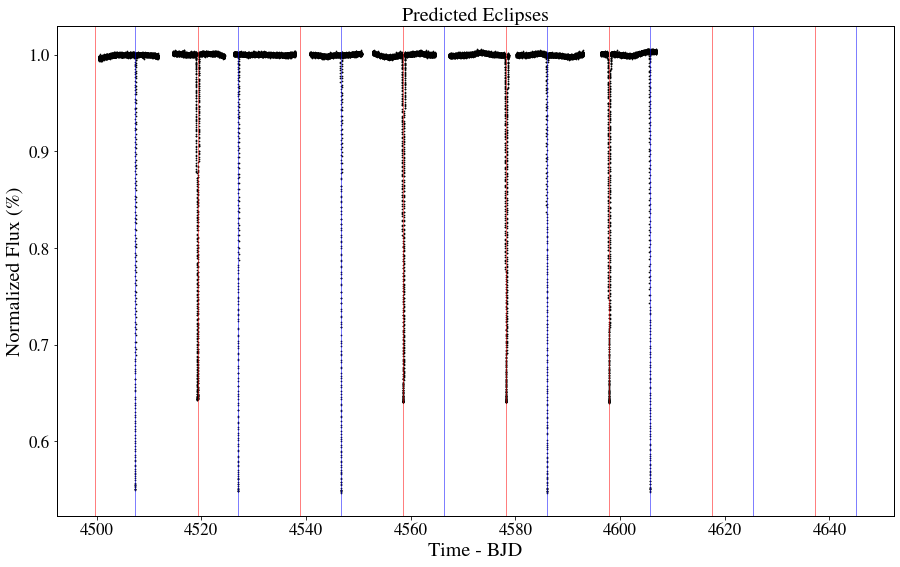

In [16]:
fig = plt.figure(figsize=(15,9), facecolor = (1,1,1))
plt.title('Predicted Eclipses',fontsize=20)
plt.xlabel('Time - BJD')
plt.ylabel('Normalized Flux (%)')
plt.scatter(MASTER_TABLE['TIME'], MASTER_TABLE['FLUX'], c='k', s=0.5)
#plt.xlim(MASTER_TABLE['TIME'][0]-best_P,2200)
#plt.ylim(0.5,1.1)
for key in pred_cycles:
    plt.axvline(pred_cycles[key][0],ls='-',c='r',lw=0.5)
    plt.axvline(pred_cycles[key][1],ls='-',c='b',lw=0.5)
    
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show();

# Detrender

In [17]:
# imports
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import scipy.optimize
import math

# supporting functions
def chi_sq(data_T, model):
    y_obs = data_T['FLUX']
    sigma = data_T['FLUX_ERR']
    chisq = 0
    for i in range(0,len(y_obs)):
        chisq += (y_obs[i] - model[i])**2 / sigma[i]**2
    return chisq

# degrees of freedom for reduced chisquare
def reduce_chisq(data_T, model, free_parameters):
    chisq = chi_sq(data_T, model)
    dof = len(data_T) - free_parameters
    return chisq / dof

def parabolic_fit(data_T):
    def parabola(x, a, b, c):
        return a*x**2 + b*x + c
    x = np.array(data_T['TIME'])
    fit_params, pcov = scipy.optimize.curve_fit(parabola, x, np.array(data_T['FLUX']))
    model = parabola(x, *fit_params)
    return model

# clip 3 sigma away from non-parabolic data
def clipper(data_T):
    # clip the data
    clip_high = np.median(data_T['FLUX']) + 3*np.std(data_T['FLUX'])
    clip_low = np.median(data_T['FLUX']) - 3*np.std(data_T['FLUX'])
    print('CLIP HIGH =', clip_high)
    print('CLIP LOW =', clip_low)
    w = data_T['FLUX'] < clip_high
    data_T = data_T[w]
    w = data_T['FLUX'] > clip_low
    data_T = data_T[w]
    return data_T

def gapper(data_T, dtl=1):
    '''dtl - is the time in days that the data will be split if it exceeds'''
    data_2 = data_T
    tables = []
    w = []
    for t in range(0,len(data_T['TIME'])-1):
        tn = data_T['TIME'][t]
        tnp1 = data_T['TIME'][t+1]
        dt = tnp1 - tn
        if dt > 1:
            w = data_2['TIME'] < tnp1
            tables.append(data_2[w])
            w = data_2['TIME'] > tn
            data_2 = data_2[w]
    tables.append(data_2)
    return tables

# detrend the data by fitting a cubic
def cubic_detrender(data_T):
    df = data_T.to_pandas()
    N = 3 # cubic
    X = df['TIME'].values
    X = np.reshape(X, (len(X),1))
    y = df['FLUX'].values
    pf = PolynomialFeatures(degree=N)
    Xp = pf.fit_transform(X)
    md2 = LinearRegression()
    md2.fit(Xp, y)
    trendp = md2.predict(Xp)
    detrpoly = [y[i] / trendp[i] for i in range(0, len(y))]
    #detrpoly = [detrpolyi[i] + med_lc for i in range(0, len(y))]
    plt.plot(X,detrpoly)
    plt.plot(X,y, c='k')
    plt.plot(X, trendp, c='orange')
    plt.show();
    data_T['FLUX'] = detrpoly
    
    r2 = r2_score(y, trendp)
    rmse = np.sqrt(mean_squared_error(y, trendp))
    print('r2:', r2)
    print('rmse', rmse)
    return data_T, X, trendp, y, rmse

def cubic_eclipse_detrender(shoulder_T, eclipse_T):
    shoulder_T.sort('TIME', reverse=True)
    df = shoulder_T.to_pandas()
    N = 3 # cubic
    X = df['TIME'].values
    X = np.reshape(X, (len(X),1))
    y = df['FLUX'].values
    y_err = df['FLUX_ERR'].values
    pf = PolynomialFeatures(degree=N)
    Xp = pf.fit_transform(X)
    md2 = LinearRegression()
    md2.fit(Xp, y)
    trendp = md2.predict(Xp)
    detrpoly = [y[i] / trendp[i] for i in range(0, len(y))]
    detrpoly_err = [y_err[i] / trendp[i] for i in range(0, len(y))]
    #detrpoly = [detrpolyi[i] + med_lc for i in range(0, len(y))]
    shoulder_T['FLUX'] = detrpoly
    shoulder_T['FLUX_ERR'] = detrpoly_err
    
    if len(eclipse_T) > 0:
        eclipse_T.sort('TIME', reverse=True)
        dfe = eclipse_T.to_pandas()
        Xe = dfe['TIME'].values
        Xe = np.reshape(Xe, (len(Xe),1))
        ye = dfe['FLUX'].values
        ye_err = df['FLUX_ERR'].values
        Xpe = pf.fit_transform(Xe)
        trendpe = md2.predict(Xpe)
        detrpolye = []
        for i in range(0, len(ye)):
            try:
                detrpolye.append(ye[i] / trendpe[i])
            except:
                detrpolye.append(np.median(detrpolye))
        detrpolye_err = []
        for i in range(0, len(ye)):
            try:
                detrpolye_err.append(ye_err[i] / trendpe[i])
            except:
                detrpolye_err.append(np.median(detrpolye_err))
        eclipse_T['FLUX'] = detrpolye
        eclipse_T['FLUX_ERR'] = detrpolye_err
        data_T = vstack([shoulder_T, eclipse_T])
    else:
        data_T = shoulder_T
    
    data_T.sort('TIME', reverse=True)
    plt.plot(data_T['TIME'], data_T['FLUX'])
    plt.plot(X,y, c='k')
    plt.plot(X, trendp, c='orange')
    plt.ylim(0.995,1.005)
    plt.show();
    
    r2 = r2_score(y, trendp)
    rmse = np.sqrt(mean_squared_error(y, trendp))
    print('r2:', r2)
    print('rmse', rmse)
    return data_T, rmse


# main detrending function
def main_detrender(DATA, best_P, pred_cycles, prim_width, prim_exact, sec_width, sec_exact, mode='eclipse'):

    header = ['TIME', 'FLUX', 'FLUX_ERR']
    raw_T = Table([[],[],[]], names = header)
    cleaned_data = Table([[],[],[]], names=header)
    for data in DATA:
        raw_T = vstack([raw_T, data])

    print('DATA POINTS =', len(raw_T))
    print('Splitting Data By Eclipse Times')
    primary_half = prim_width*best_P
    exact_primary = prim_exact*best_P
    secondary_half = sec_width*best_P
    exact_sec = sec_exact*best_P
    p_eclipse_start = []
    p_eclipse_end = []
    p_exact_start = []
    p_exact_end = []
    s_eclipse_start = []
    s_eclipse_end = []
    s_exact_start = []
    s_exact_end = []
    wtp = [] # true in primary
    wtpe = [] # true in exact
    wts = [] # true in secondary
    wtse = [] # true in exact
    wf = [] # located outside of the eclipse range
    
    for cycle in pred_cycles:
        primary = pred_cycles[cycle][0]
        p_eclipse_start.append(primary-primary_half)
        p_eclipse_end.append(primary+primary_half)
        p_exact_start.append(primary-exact_primary)
        p_exact_end.append(primary+exact_primary)
        secondary = pred_cycles[cycle][1]
        s_eclipse_start.append(secondary-secondary_half)
        s_eclipse_end.append(secondary+secondary_half)
        s_exact_start.append(secondary-exact_sec)
        s_exact_end.append(secondary+exact_sec)
        
    for row in raw_T:
        for i in range(0, len(p_eclipse_start)):
            in_eclipse = False
            if row['TIME'] >= p_exact_start[i] and row['TIME'] <= p_exact_end[i]:
                wtp.append(False)
                wtpe.append(True)
                wts.append(False)
                wtse.append(False)
                wf.append(False)
                in_eclipse = True
                break
            elif row['TIME'] >= s_exact_start[i] and row['TIME'] <= s_exact_end[i]:
                wtp.append(False)
                wtpe.append(False)
                wts.append(False)
                wtse.append(True)
                wf.append(False)
                in_eclipse = True
                break
            elif row['TIME'] >= p_eclipse_start[i] and row['TIME'] <= p_eclipse_end[i]:
                wtp.append(True)
                wtpe.append(False)
                wts.append(False)
                wtse.append(False)
                wf.append(False)
                in_eclipse = True
                break
            elif row['TIME'] >= s_eclipse_start[i] and row['TIME'] <= s_eclipse_end[i]:
                wtp.append(False)
                wtpe.append(False)
                wts.append(True)
                wtse.append(False)
                wf.append(False)
                in_eclipse = True
                break
            else:
                None
        if in_eclipse == False:
            wtp.append(False)
            wtpe.append(False)
            wts.append(False)
            wtse.append(False)
            wf.append(True)
                
    # out of eclipse data
    safe_T = raw_T[wf]
    # primary eclipse data
    prim_T = raw_T[wtp] 
    #secondary eclipse data
    sec_T = raw_T[wts]
    # exact primary
    prim_eT = raw_T[wtpe]
    # exact secondary
    sec_eT = raw_T[wtse]
    
    # combined table of eclipses
    shoulder_T = vstack([prim_T,sec_T])
    eclipse_T = vstack([prim_eT, sec_eT])
    

    plt.figure(figsize=(8,7))
    plt.scatter(safe_T['TIME'],safe_T['FLUX'], c='k', s=0.5)
    plt.scatter(prim_T['TIME'],prim_T['FLUX'], c='skyblue', s=0.5)
    plt.scatter(sec_T['TIME'],sec_T['FLUX'], c='red', s=0.5)
    plt.scatter(prim_eT['TIME'],prim_eT['FLUX'], c='navy', s=0.5)
    plt.scatter(sec_eT['TIME'],sec_eT['FLUX'], c='orange', s=0.5)
    #plt.xlim(3400,3600)
    plt.show()
    print('Determining Eclipse Data validity')
    
    # we need to prepare the data for the cubic detrender
    def eclipse_gapper(shoulder_data, eclipse_data, p_eclipse_start, p_eclipse_end, s_eclipse_start, s_eclipse_end):
        #for grabbing the shoulder data and combining it with the in eclipse data
        table_array = [] # form [(shoulder, exact)]

        # start with the primary eclipses
        for i in range(len(p_eclipse_start)):
            wps = shoulder_data['TIME'] >= p_eclipse_start[i]
            wpes = eclipse_data['TIME'] >= p_eclipse_start[i] # exact
            wpe = shoulder_data['TIME'] <= p_eclipse_end[i]
            wpee = eclipse_data['TIME'] <= p_eclipse_end[i] # exact
            wsh = []
            wec = []
            for n in range(len(wps)):
                if wps[n] == True and wpe[n] == True:
                    wsh.append(True)
                else:
                    wsh.append(False)
            for n in range(len(wpes)):
                if wpes[n] == True and wpee[n] == True:
                    wec.append(True)
                else:
                    wec.append(False)
            shoulder_T = shoulder_data[wsh]
            eclipse_T = eclipse_data[wec]
            
            if len(shoulder_T) == 0 and len(eclipse_T) == 0:
                None
            
            elif len(eclipse_T) == 0:
                table_array.append((shoulder_T, eclipse_T))
            
            else:

                # make sure the shoulders extend past the exact eclipses by adding a data point
                try:
                    if np.min(shoulder_T['TIME']) > np.min(eclipse_T['TIME']):
                        t = p_eclipse_start[i]
                        shoulder_T.add_row([t,shoulder_T['FLUX'][0],shoulder_T['FLUX_ERR'][0]])
                    if np.max(shoulder_T['TIME']) < np.max(eclipse_T['TIME']):
                        t = p_eclipse_end[i]
                        shoulder_T.add_row([t,shoulder_T['FLUX'][-1],shoulder_T['FLUX_ERR'][0]])
                        
                except:
                    # case with no shoulder times and possibly no eclipse times
                    t = p_eclipse_start[i]
                    shoulder_T.add_row([t,1,0.0001])
                    t = p_eclipse_end[i]
                    shoulder_T.add_row([t,1,0.0001])

                shoulder_T.sort('TIME', reverse=True)
                table_array.append((shoulder_T, eclipse_T))
                                   
        # secondary eclipses
        for i in range(len(p_eclipse_start)):
            wps = shoulder_data['TIME'] >= s_eclipse_start[i]
            wpes = eclipse_data['TIME'] >= s_eclipse_start[i] # exact
            wpe = shoulder_data['TIME'] <= s_eclipse_end[i]
            wpee = eclipse_data['TIME'] <= s_eclipse_end[i] # exact
            wsh = []
            wec = []
            for n in range(len(wps)):
                if wps[n] == True and wpe[n] == True:
                    wsh.append(True)
                else:
                    wsh.append(False)
            for n in range(len(wpes)):
                if wpes[n] == True and wpee[n] == True:
                    wec.append(True)
                else:
                    wec.append(False)
            shoulder_T = shoulder_data[wsh]
            eclipse_T = eclipse_data[wec]
            
            if len(shoulder_T) == 0 and len(eclipse_T) == 0:
                None
            
            elif len(eclipse_T) == 0:
                table_array.append((shoulder_T, eclipse_T))
            
            else:

                # make sure the shoulders extend past the exact eclipses by adding a data point
                try:
                    if np.min(shoulder_T['TIME']) > np.min(eclipse_T['TIME']):
                        t = s_eclipse_start[i]
                        shoulder_T.add_row([t,shoulder_T['FLUX'][0],shoulder_T['FLUX_ERR'][0]])
                    if np.max(shoulder_T['TIME']) < np.max(eclipse_T['TIME']):
                        t = s_eclipse_end[i]
                        shoulder_T.add_row([t,shoulder_T['FLUX'][-1],shoulder_T['FLUX_ERR'][0]])
                        
                except:
                    # case with no shoulder times and possibly no eclipse times
                    t = s_eclipse_start[i]
                    shoulder_T.add_row([t,1,0.0001])
                    t = s_eclipse_end[i]
                    shoulder_T.add_row([t,1,0.0001])

                shoulder_T.sort('TIME', reverse=True)
                table_array.append((shoulder_T, eclipse_T))
        
        return table_array
    
    table_array = eclipse_gapper(shoulder_T, eclipse_T, p_eclipse_start, p_eclipse_end, s_eclipse_start, s_eclipse_end)
    
    print('Detrending Eclipses')
    
    # detrend the eclipse data
    clean_Ts = []
    for tup in table_array:
        temp_T, rmse = cubic_eclipse_detrender(tup[0], tup[1])
        if rmse <= 0.02:
            clean_Ts.append(temp_T)
        else:
            print('RMSE TOO HIGH, DATA REJECTED')
            
    CLEANED_COMBINED = vstack(clean_Ts)
    CLEANED_COMBINED.sort('TIME', reverse=True)
    return CLEANED_COMBINED
        

### How to run?

After pred_cycles edit the following based on the phased display plot fitting done in the string length module.

1) prim_width - make larger than the exact values of the primary eclipse (units are in phase). Must be larger to capture the out of eclipse trends.

2) prim_exact - exact values of the eclipse width of the primary eclipse (units are in phase). Must exactly match ingress and egress of the eclipse.

3) sec_width - make larger than the exact values of the secondary eclipse (units are in phase). Must be larger to capture the out of eclipse trends.

4) sec_exact - exact values of the secondary width of the primary eclipse (units are in phase). Must exactly match ingress and egress of the eclipse.

DATA POINTS = 64294
Splitting Data By Eclipse Times


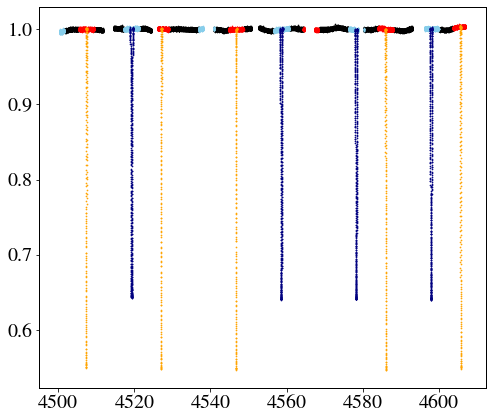

Determining Eclipse Data validity
Detrending Eclipses


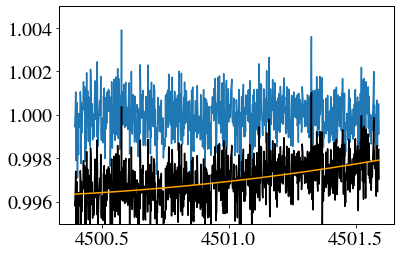

r2: 0.18820153240647475
rmse 0.0009492256265888511


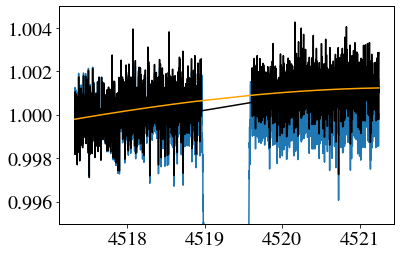

r2: 0.2103256539792927
rmse 0.0009037189209016593


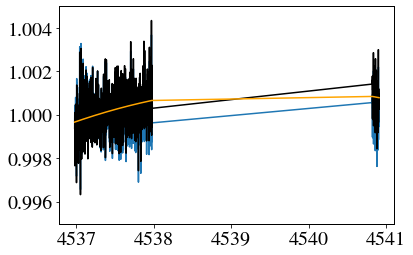

r2: 0.10408706100003351
rmse 0.0009496917598574117


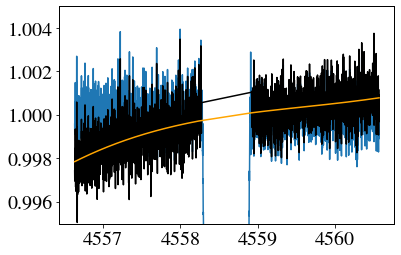

r2: 0.48862372686455924
rmse 0.0008763621842461591


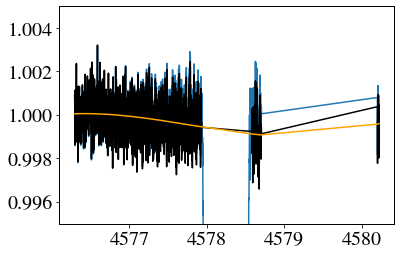

r2: 0.07910893172784728
rmse 0.0009013710949321835


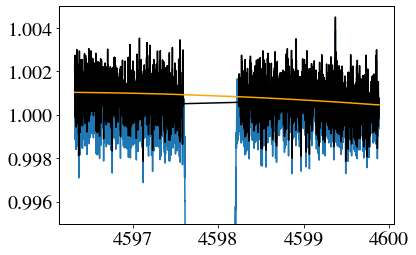

r2: 0.03923827312020145
rmse 0.0009136217729032655


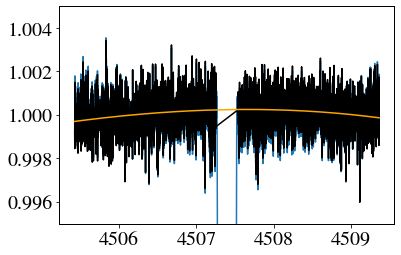

r2: 0.02644970986785411
rmse 0.0009008543512750524


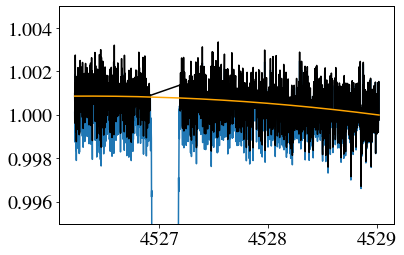

r2: 0.08008443718978686
rmse 0.000895325775388041


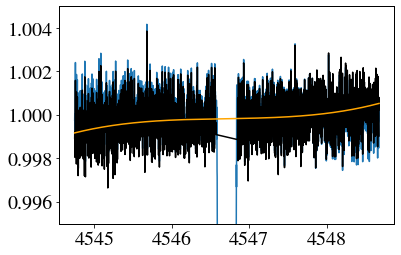

r2: 0.07295912686859196
rmse 0.0008737559786278479


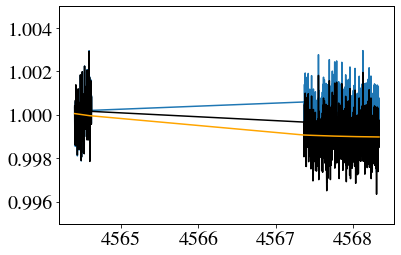

r2: 0.1529191915274215
rmse 0.0008999635759948108


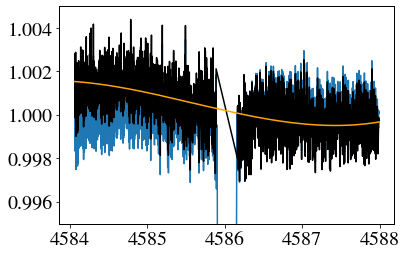

r2: 0.3867469806804217
rmse 0.0009401277899056753


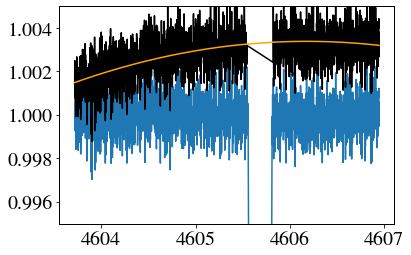

r2: 0.3016887725168015
rmse 0.0008526520704137884


In [18]:
DETRENDED_DATA = main_detrender(DATA,best_P, pred_cycles, 0.1,0.0165,0.1,0.007)

plot demonstrating detrending of light curve

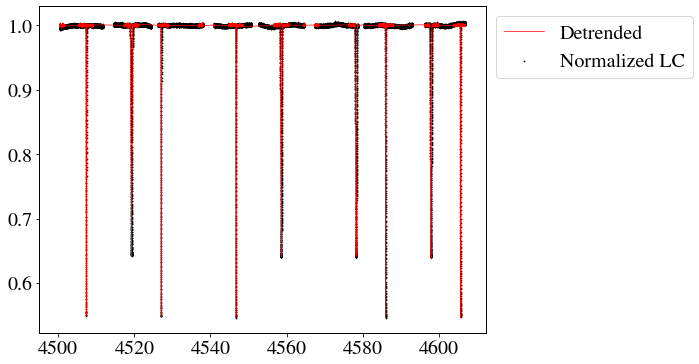

In [19]:
fig = plt.figure(figsize=(8,6), facecolor=(1,1,1))
#plt.title('DETRENDED DATA')
plt.plot(DETRENDED_DATA['TIME'], DETRENDED_DATA['FLUX'], lw=0.7, c= 'r', zorder=20,label='Detrended')
plt.scatter(MASTER_TABLE['TIME'], MASTER_TABLE['FLUX'], c='k', s=0.5, zorder=10, label='Normalized LC')
#plt.ylim(0.995,1.006)
#plt.xlim(4527.5,4528)
#plt.ylim(0.99,1.01)
plt.legend(bbox_to_anchor=(1,1),fontsize=20)
plt.show();

## Run the following cell to download the detrended lightcurve

will be found in the specified download folder for the system

In [20]:
out_path = download_path + '/' + tic_id[4:] + '/' + f'{tic_id[4:]}_detrended.dat'
f = open(out_path, 'w+')
for row in DETRENDED_DATA:
    f.write("{}    {}    {}\n".format(row['TIME'], row['FLUX'], row['FLUX_ERR']))
f.close()

print(f'DETRENDED DATA WRITTEN TO {out_path}')

DETRENDED DATA WRITTEN TO lc_downloads/172900988/172900988_detrended.dat
